# Investigate Weak formulation of ode solution for loss
Consider the stiff ode 

$$
\dot{x} = F(x;u), \quad x \in \Omega \subseteq \mathbb{R}^d
$$

Where we wish to learn $F$ via a paremterized $F_\theta$ via some (possibly noisy) observations $\{x_i\}_{i=1}^n$
Consider the test function $\{\phi_k\}_{k\in[K]} \in H^1$ (sobolev space) that is locally compact on an interval $T$ and a fixed $k$ we have

$$
\int_T \phi_k(t) \dot{x} dt = \int_T \phi_i(t)F(x;u)  dt
$$
$$
\underbrace{\phi_k(t)x \bigg|_{\partial T}}_{=0} - \int_T  \dot{\phi}_k(t)x(t)dt = \int_T \phi_k(t)F(x;u)  dt
$$

We can then define the following residual

$$
R_k(\theta) = \int_T \underbrace{\left(\dot{\phi}_k(t) x(t) + \phi_k(t) F_\theta(x;u)\right)}_{=I_k(t)}dt
$$
where can use a trapezodial rule to approximate the integral

$$
R_k \approx \hat{R}_k \triangleq \sum_{i=1}^{n-1} \frac{\Delta t_i}{2} \left[I_k(t_i) + I_k(t_{i+1})\right] = \mathcal{O}(\Delta t ^{p+1})
$$


<!-- $$
I_k(\theta)\triangleq \sum_{i=1}^n w_i \cdot \phi_k(t_i)\cdot F_\theta(x_i;u_i)\cdot\Delta t_i
$$
$$
D_k \triangleq -1 \cdot \sum_{i=1}^n w_i \cdot x_i \cdot \dot{\phi}_k(t_i)\cdot \Delta t_i
$$

to be quadrature approximations of the integrals above -->

We then define the least squares loss to be

$$
\mathcal{L}(\theta) \triangleq \sum_{k=1}^K \left| \hat{R}_k(\theta) \right|^2.
$$

Where the loss $\mathcal{L}$ can be minimzed in a classical optimizaiton approach. As well as NODE approach. Where we first try and let 

$$
F_\theta(x;u) := \texttt{StabNODE(Felu, Gelu)}
$$

where $\theta$ are the tunable parameters in $\texttt{Felu}$ and $\texttt{Gelu}$


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from stabnode.utils import set_global_seed
from sklearn.preprocessing import MinMaxScaler

seed = 1234
set_global_seed(seed=seed)

### Test functions ($\phi$) from [Weak SINDY: Galerkin-based Data-Driven Model Selection](https://arxiv.org/abs/2005.04339) 

Let $\mathcal{S}$ be the space of unimodal piecewise polynomials

$$
\phi(t) = \begin{cases}
    C(t-a)^p(b-t)^q, & t \in [a,b]\\
    0, & \text{otherwise},
\end{cases}
$$
with $(a,b) \subset t\times t$, $a<b$, and $p,q \geq 1$. And the normalization constant give by 
$$
C = \frac{1}{p^p q^q}\left(\frac{p+q}{b-a}\right)^{p+q}
$$

We also include the first derivative



$$
\partial_t \phi(t) = \begin{cases}
C \bigg(p(t-a)^{p-1}(b-t)^q - (t-a)^pq(b-t)^{q-1}\bigg), & t\in [a,b]\\
0, & \text{otherwise},
\end{cases}
$$

In [2]:
# a,b,p,q = 1,4,1,1
def phi(t:torch.Tensor,a:float,b:float,p:float,q:float)->torch.Tensor:
    C = (1 / ((p**p)*(q**q)))*((p+q)/(b-a))**(p+q)
    vals = torch.zeros_like(t)
    mask = (t>a) & (t<b)
    vals[mask] = C*(t[mask]-a)**p*(b-t[mask])**q
    return vals

def dphi(t:torch.Tensor,a:float,b:float,p:float,q:float)->torch.Tensor:
    C = (1 / ((p**p)*(q**q)))*((p+q)/(b-a))**(p+q)
    vals = torch.zeros_like(t)
    mask = (t>a) & (t<b)
    term1 = p*(t[mask]-a)**(p-1)*(b-t[mask])**q
    term2 = (t[mask]-a)**p*q*(b-t[mask])**(q-1)
    vals[mask] = C*(term1-term2)
    return vals


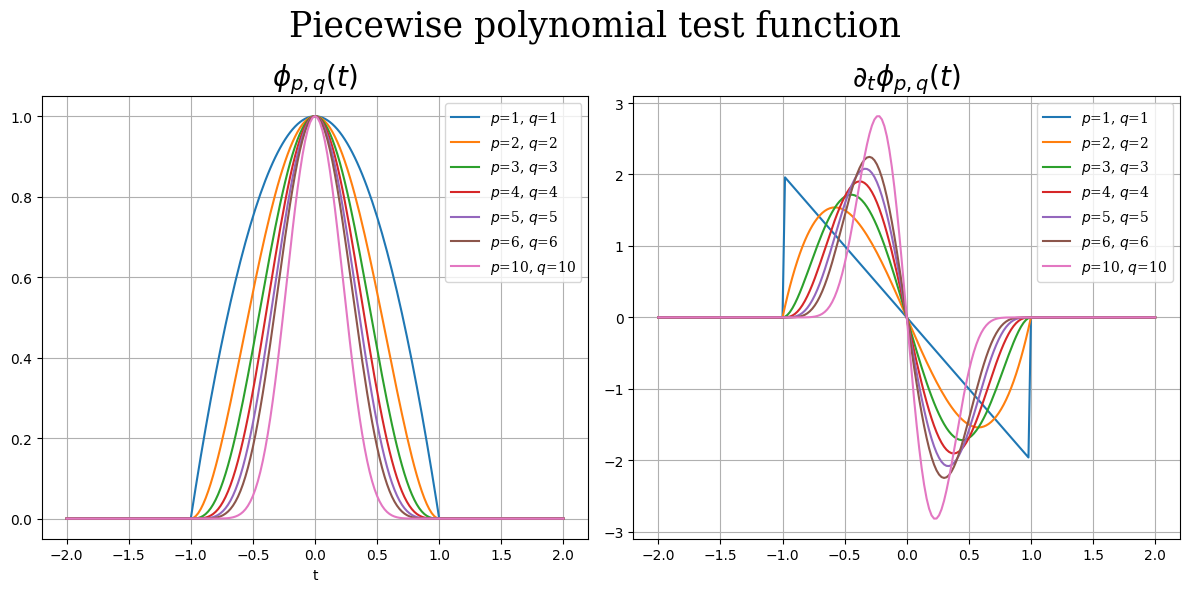

In [3]:
fig, (ax1,ax2)  = plt.subplots(1,2,figsize=(12,6))

t_vals = torch.linspace(-2,2,201)
a,b=-1,1
ps = [1,2,3,4,5,6,10]
qs = [1,2,3,4,5,6,10]
for p,q in zip(ps,qs):
    label = rf"$p$={p}, $q$={q}"
    ax1.plot(t_vals,phi(t_vals,a,b,p,q),label=label)
    ax2.plot(t_vals,dphi(t_vals,a,b,p,q),label=label)
ax1.grid(True)
ax1.set_title(r"$\phi_{p,q}(t)$",size=20,family='serif')
ax1.set_xlabel(r"t")
ax1.legend(prop={'family':'serif'})
ax2.grid(True)
ax2.set_title(r"$\partial_t\phi_{p,q}(t)$",size=20,family='serif')
ax2.legend(prop={'family':'serif'})
plt.suptitle("Piecewise polynomial test function",family='serif',size=25)
plt.tight_layout()
plt.savefig("piecewise_poly_test_functions.png")
plt.show()

In [4]:
from stabnode.node import StabNODE, Felu, Gelu
from data.hysteresis import simulate_steady_state

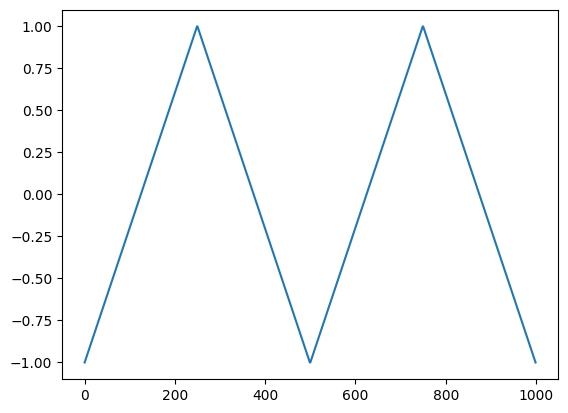

In [5]:
lam_start = -1 
lam_end = 1

n_points = 250

lam_increase = np.linspace(lam_start,lam_end, n_points)
lam_decrease = np.linspace(lam_end, lam_start, n_points)

lam_np = np.hstack((lam_increase,lam_decrease))
repeat = 1
for _ in range(repeat):
    lam_np = np.hstack((lam_np, lam_np))
plt.plot(lam_np)
plt.show()


In [6]:
X, lam, t=simulate_steady_state(lam_np,x0=-1.31,t_span=[0,20],t_eval=np.linspace(0,20,201))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X.T)
X_scaled= scaler.transform(X.T).T
X_scaled = torch.tensor(X_scaled, dtype=torch.float32, device='cpu')

In [8]:
interp_lam = interp1d(t.numpy(), lam.numpy(), axis=0, kind='linear')

def control_func(t: torch.Tensor) -> torch.Tensor:
    """
    t: Tensor of shape [B] or scalar
    Returns: Tensor of shape [B, 1]
    """
    if t.dim() == 0:  # scalar time
        t_scalar = t.item()
        lam_t = torch.tensor(interp_lam(t_scalar), dtype=torch.float32)
        return lam_t.unsqueeze(0)
    else:  # batched time
        lam_t = interp_lam(t.detach().cpu().numpy())  # shape [B,]
        lam_t = torch.tensor(lam_t, dtype=torch.float32).unsqueeze(1)  # shape [B, 1]
        return lam_t.to(t.device)

In [9]:
sample_rate =100
train_idx = torch.arange(0,len(t),sample_rate)
X_train = X_scaled[:,train_idx]
t_train = t[train_idx]
lam_train = lam[train_idx]

In [10]:
f = Felu(1,1,4)
g = Gelu(2,1,2)

model = StabNODE(f,g).to('cpu')

In [11]:
# i=1
# model.f(X_train[:,i])

In [12]:
# t_train[i], X_train[:,i], control_func(t_train[i])

In [13]:
# X[:,:10].T.shape, control_func(t_train[:10]).shape

In [14]:
# test = torch.cat([X[:,:10].T,control_func(t_train[:10])],dim=-1)

In [15]:
# test

In [16]:
# model.g.network(test)

In [17]:
# i=1
# model(t_train[i:i+1],X_train[:,i],control_func)

In [18]:
# control_func(t[:10]).shape


In [19]:
from stabnode.utils import _load_loop_wrapper

decay_rate = 1000
dt = t[1:] - t[:-1]
dt = torch.cat((dt[0:1],dt,dt[-2:-1]))
phi_order = 5
def phi_k(i,k):
    ti = t[i]
    tk = t[k]
    return phi(ti,a=tk-decay_rate*dt[k],b=tk+decay_rate*dt[k+1],p=phi_order,q=phi_order)

def weak_MSELoss(t,X,model,control_func, phi_order, decay_rate,show_progress=True):
    dt = t[1:] - t[:-1]
    dt = torch.cat((dt[0:1],dt,dt[-2:-1]))

    def phi_k(i,k):
        ti = t[i]
        tk = t[k]
        return phi(ti,a=tk-decay_rate*dt[k],b=tk+decay_rate*dt[k+1],p=phi_order,q=phi_order)

    def dphi_k(i,k):
        ti=t[i]
        tk = t[k]
        return dphi(ti,a=tk-decay_rate*dt[k],b=tk+decay_rate*dt[k+1],p=phi_order,q=phi_order)

    def integrand(i,k):
        xi = X[:,i].T
        ti = t[i]
        return dphi_k(i,k)*xi.squeeze()+phi_k(i,k)*model(ti,xi, control_func).squeeze()

    def trapezoid(k):
        indices = torch.arange(len(t))
        I = integrand(indices,k)
        trap = (dt[1:-1] / 2 ) * (I[:-1]+I[1:])
        return trap    

    K = len(t)
    weak_loss = 0.0
    loop_wrapper = _load_loop_wrapper(show_progress)
    for k in loop_wrapper(range(K)):
        weak_loss += torch.sum(trapezoid(k)**2)
    
    return weak_loss / K


In [20]:
X_scaled.shape

torch.Size([1, 200001])

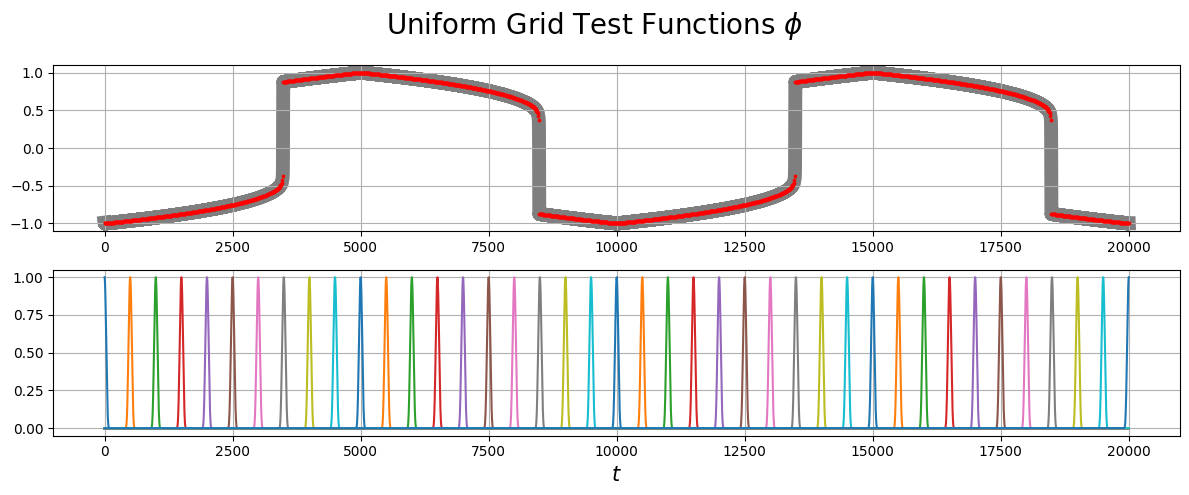

In [21]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,5))
k_vals = torch.arange(0,len(t),5000)
indices = torch.arange(len(t))

ax1.plot(t,X_scaled[0,:],c='black',alpha=0.5,lw=10,zorder=1)
ax1.scatter(t_train, X_train,zorder=2,c='red',s=3)
ax1.grid(True)
k_vals=train_idx
for k in k_vals[::50]:
    ax2.plot(t,phi_k(indices,k))

ax2.set_xlabel(r"$t$",size=15)
ax2.grid(True)
plt.tight_layout(rect=[0,0,1,0.9])
plt.suptitle(r"Uniform Grid Test Functions $\phi$", size=20)
plt.show()

In [22]:
# # test loss
# print(t_train.shape, X_train.shape)
# loss = weak_MSELoss(t_train, X_train, model, control_func, phi_order = 5, decay_rate=1000)
# loss

# format data

In [23]:
from stabnode.data import TrajectoryDataset

train_dataset = TrajectoryDataset(X_train.T, t_train, window_size=None)
len(train_dataset)

1

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

In [25]:
# for out in train_loader:
#     xi,ti,_ = out
#     loss = weak_MSELoss(ti.squeeze(),xi.squeeze().reshape(1,-1),model,control_func,phi_order=5,decay_rate=1000)
#     print(loss)

In [26]:
# xi.squeeze().reshape(1,-1)

### train model

In [ ]:
import time

n_epochs = 20
lr = 1e-1
show_progress = True
phi_order = 5
decay_rate=1000
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = lr)


loop_wrapper = _load_loop_wrapper(show_progress)
loop_wrapper2 = _load_loop_wrapper(True)

model.train()
losses = []
times = []

Xi_epoch_predictions = []
Tis_epoch = []
for epoch in loop_wrapper(range(n_epochs)):
    t1 = time.time()
    epoch_loss = 0.0
    num_batches = 0
    epoch_losses = []

    Xi_predictions = []
    Tis = []
    for Xi, Ti, _ in loop_wrapper2(train_loader):
        Xi = Xi.squeeze().reshape(1,-1) # [batch, time, dim]
        Ti = Ti.squeeze()

        if not Xi.requires_grad:
            Xi = Xi.clone().detach().requires_grad_()


        opt.zero_grad()
        loss = weak_MSELoss(
            t=Ti,
            X = Xi,
            model=model,
            control_func=control_func,
            phi_order=phi_order,
            decay_rate=decay_rate,
            show_progress=False
        )

        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())
        epoch_loss += loss.item()
        num_batches += 1

    Xi_epoch_predictions.append(Xi_predictions)
    Tis_epoch.append(Tis)
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)

    t2 = time.time()
    times.append(t2 - t1)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
losses

[1.225655198097229,
 0.25050845742225647,
 0.11936210840940475,
 0.09387217462062836,
 0.07498833537101746,
 0.05388997495174408,
 0.036498069763183594,
 0.024405356496572495,
 0.01659010536968708,
 0.011657055467367172]

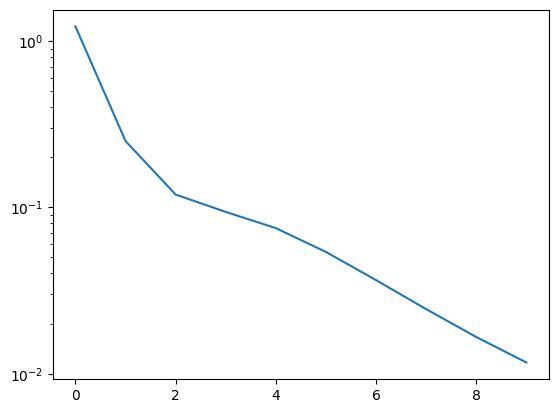

In [33]:
plt.plot(losses)
plt.yscale('log')
plt.show()

## Look at learned `g` and `f`

In [44]:
def f_true(x):
    return -1*x**2

def g_true(x,lam):
    return (1/x)*(lam/x+1)

In [56]:
g_true_scaled_out = scaler.transform(g_true(X[:,train_idx].squeeze(),lam_train).reshape(-1,1))
f_true_scaled_out = f_true(X[:,train_idx].squeeze())

In [ ]:
g = model.g
f = model.f
g.eval()
f.eval()

Gelu(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Tanh()
  )
)

In [37]:
X_train.shape, control_func(t_train).shape

(torch.Size([1, 2001]), torch.Size([2001, 1]))

In [42]:
with torch.no_grad():
    g_out = g(X_train.T, control_func(t_train))
    f_out = f(X_train.T)

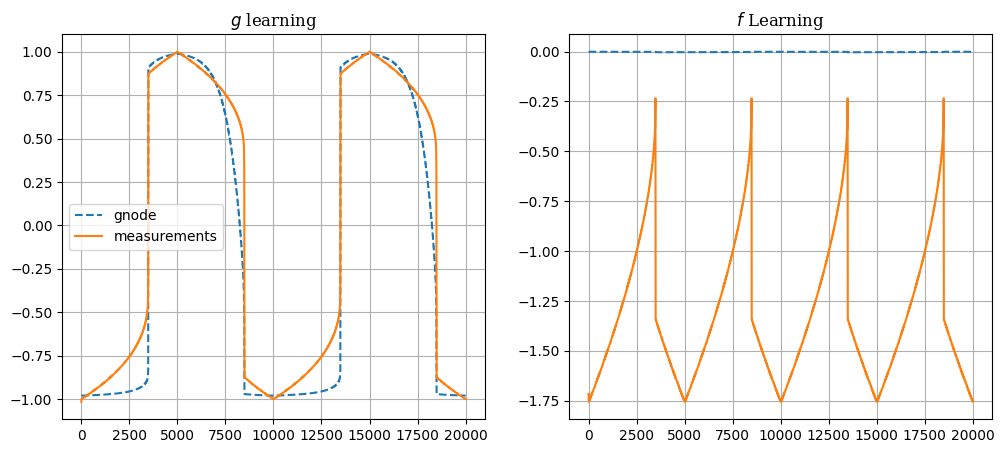

In [67]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(t_train,g_out.squeeze(),linestyle='--',label='gnode')
ax1.plot(t_train,g_true_scaled_out,label="measurements")
ax1.grid(True)
ax1.set_title(r"$g$ learning", family='serif')
ax1.legend()

ax2.plot(t_train,f_out.squeeze(),linestyle='--', label='fnode')
ax2.plot(t_train,f_true_scaled_out, label='measurements')
ax2.set_title(r"$f$ Learning", family='serif')
ax2.grid(True)
plt.show()